# Prepare Data for Training & Validating & Testing
# Hierarchical model

## Dataset
- [**IMDB Large Movie Review Dataset**](http://ai.stanford.edu/~amaas/data/sentiment/)
    - Binary sentiment classification
    - Citation: [Andrew L. Maas et al., 2011](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)
    - 50,000 movie reviews for training and testing
    - Average review length: 231 vocab
    ---
- [**Yelp reviews-full**](http://xzh.me/docs/charconvnet.pdf)
    - Multiclass sentiment classification (5 stars)
    - Citation: [Xiang Zhang et al., 2015](https://arxiv.org/abs/1509.01626)
    - 650,000 training samples and 50,000 testing samples (Nums of each star are equal)
    - Average review length: 140 vocab
    ---
- [**Yelp reviews-polarity**](http://xzh.me/docs/charconvnet.pdf)
    - Binary sentiment classification
    - Citation: [Xiang Zhang et al., 2015](https://arxiv.org/abs/1509.01626)
    - 560,000 training samples and 38,000 testing samples (Nums of positive or negative samples are equal)
    - Average review length: 140 vocab
    ---
- [**Douban Movie Reviews**](https://drive.google.com/open?id=1DsmQfB1Ff_BUoxOv4kfUMg7Y8M7tHB9F) 
    - My Custom Chinese movie reviews dataset scraped by python extension package requests
    - Binary sentiment classification
    - 750,000 movie reviews from [Douban](https://movie.douban.com/), 650,000 samples for training and 100,000 samples for testing (Num of positive or negative samples is equal)
    - Average review length: 52 character, 28 vocab

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import re
from functools import partial
warnings.filterwarnings('ignore')

from utils import process, process_zh
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMDB

In [2]:
df = pd.read_csv('dataset/IMDB/imdb_master.csv', encoding='latin-1')

In [3]:
df = df[df['label'] != 'unsup']
df['label'] = df['label'].map({'neg':0, 'pos':1})
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,0,0_2.txt
1,1,test,This is an example of why the majority of acti...,0,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",0,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,0,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,0,10003_3.txt


In [4]:
df['Processed_Reviews'] = df['review'].apply(process)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df.label)

In [6]:
df_train, df_validate = train_test_split(df_train, test_size=5000, random_state=0, stratify=df_train.label)

In [7]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  40000
Validation set size:  5000
Test set size:  5000


In [8]:
num_words = []
def count(x):
    for sen in x:
        num_words.append(len(sen))
num_sens = df_train.Processed_Reviews.apply(len)
_ = df_train.Processed_Reviews.apply(count)

Text(0, 0.5, 'Counts')

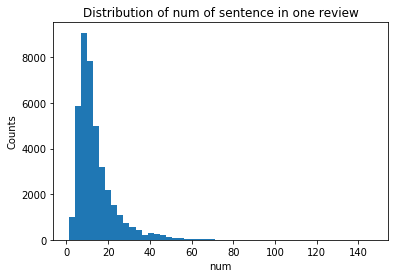

In [9]:
plt.figure()
_ = plt.hist(num_sens, bins = 50)
plt.title('Distribution of num of sentence in one review')
plt.xlabel('num')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

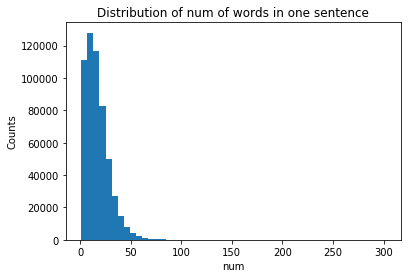

In [10]:
plt.figure()
_ = plt.hist(num_words, bins = 50)
plt.title('Distribution of num of words in one sentence')
plt.xlabel('num')
plt.ylabel('Counts')

In [11]:
word_count = {}
def count_words(x):
    for sen in x:
        for word in sen:
            word_count[word] = word_count.get(word, 0) + 1

In [12]:
_ = df_train.Processed_Reviews.apply(count_words)

In [13]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [14]:
vocab_size = 20000
df_word_count = df_word_count[:vocab_size-10]

In [15]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 10 # reverse 10 pos for padding, [UNK], [CLS]...

In [16]:
def word_to_num(x):
    res = []
    for sen in x:
        sen_words = []
        for word in sen:
            if word in word2num_series:
                sen_words.append(word2num_series[word])
        if len(sen_words) > 0:
            res.append(np.array(sen_words, dtype=np.uint16))
    return np.array(res)

In [17]:
def create_data(df):
    X = df.Processed_Reviews.apply(word_to_num)
    y = df.label
    return X, y

In [18]:
X_train, y_train = create_data(df_train)

In [ ]:
X_val, y_val = create_data(df_validate)

In [ ]:
X_test, y_test = create_data(df_test)

In [ ]:
X_train.to_hdf('dataset/IMDB/X_train.h5', key='s', model='w')
y_train.to_hdf('dataset/IMDB/y_train.h5', key='s', model='w')

X_val.to_hdf('dataset/IMDB/X_val.h5', key='s', model='w')
y_val.to_hdf('dataset/IMDB/y_val.h5', key='s', model='w')

X_test.to_hdf('dataset/IMDB/X_test.h5', key='s', model='w')
y_test.to_hdf('dataset/IMDB/y_test.h5', key='s', model='w')
word2num_series.to_hdf('dataset/IMDB/word2num_series.h5', key='s', model='w')

## Yelp Polarity

In [ ]:
df = pd.read_csv('dataset/yelp_review_polarity_csv/train.csv', header=None)
df_test = pd.read_csv('dataset/yelp_review_polarity_csv/test.csv', header=None)
df.columns = ['label', 'review']
df['label'] = df['label'].map({1:0, 2:1})
df_test.columns = ['label', 'review']
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [ ]:
df['Processed_Reviews'] = df['review'].apply(process)

In [ ]:
df_test['Processed_Reviews'] = df_test['review'].apply(process)

In [ ]:
df_train, df_validate = train_test_split(df, test_size=50000, random_state=0, stratify=df.label)

In [ ]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  510000
Validation set size:  50000
Test set size:  38000


In [ ]:
num_words = []
def count(x):
    for sen in x:
        num_words.append(len(sen))
num_sens = df_train.Processed_Reviews.apply(len)
_ = df_train.Processed_Reviews.apply(count)

Text(0, 0.5, 'Counts')

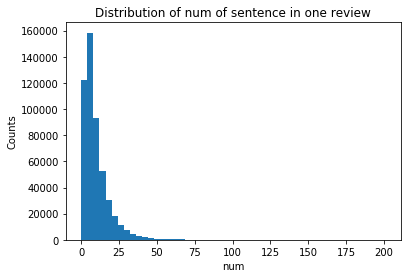

In [ ]:
plt.figure()
_ = plt.hist(num_sens, bins = 50)
plt.title('Distribution of num of sentence in one review')
plt.xlabel('num')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

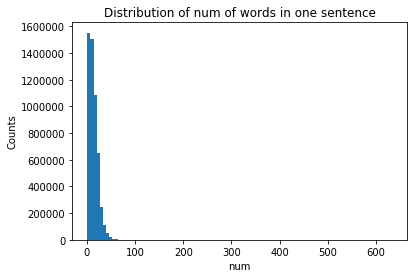

In [ ]:
plt.figure()
_ = plt.hist(num_words, bins = 100)
plt.title('Distribution of num of words in one sentence')
plt.xlabel('num')
plt.ylabel('Counts')

In [ ]:
word_count = {}
def count_words(x):
    for sen in x:
        for word in sen:
            word_count[word] = word_count.get(word, 0) + 1

In [ ]:
_ = df_train.Processed_Reviews.apply(count_words)

In [ ]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [ ]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-10]

In [ ]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 10 # reverse 10 pos for padding, [UNK], [CLS]...

In [ ]:
def word_to_num(x):
    res = []
    for sen in x:
        sen_words = []
        for word in sen:
            if word in word2num_series:
                sen_words.append(word2num_series[word])
        if len(sen_words) > 0:
            res.append(np.array(sen_words, dtype=np.uint16))
    return np.array(res)

In [ ]:
def create_data(df):
    X = df.Processed_Reviews.apply(word_to_num)
    y = df.label
    return X, y

In [ ]:
X_train, y_train = create_data(df_train)
X_val, y_val = create_data(df_validate)
X_test, y_test = create_data(df_test)

In [ ]:
data_pth = 'dataset/yelp_review_polarity_csv/'
X_train.to_hdf(data_pth + 'X_train.h5', key='s', model='w')
y_train.to_hdf(data_pth + 'y_train.h5', key='s', model='w')

X_val.to_hdf(data_pth + 'X_val.h5', key='s', model='w')
y_val.to_hdf(data_pth + 'y_val.h5', key='s', model='w')

X_test.to_hdf(data_pth + 'X_test.h5', key='s', model='w')
y_test.to_hdf(data_pth + 'y_test.h5', key='s', model='w')
word2num_series.to_hdf(data_pth + 'word2num_series.h5', key='s', model='w')

## Yelp Full

In [ ]:
data_pth = 'dataset/yelp_review_full_csv/'

In [ ]:
df = pd.read_csv(data_pth + 'train.csv', header=None)
df_test = pd.read_csv(data_pth + 'test.csv', header=None)
df.columns = ['label', 'review']
df_test.columns = ['label', 'review']

In [ ]:
df['Processed_Reviews'] = df['review'].apply(process)
df_test['Processed_Reviews'] = df_test['review'].apply(process)
df_train, df_validate = train_test_split(df, test_size=50000, random_state=0, stratify=df.label)
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  600000
Validation set size:  50000
Test set size:  50000


In [ ]:
num_words = []
def count(x):
    for sen in x:
        num_words.append(len(sen))
num_sens = df_train.Processed_Reviews.apply(len)
_ = df_train.Processed_Reviews.apply(count)

Text(0, 0.5, 'Counts')

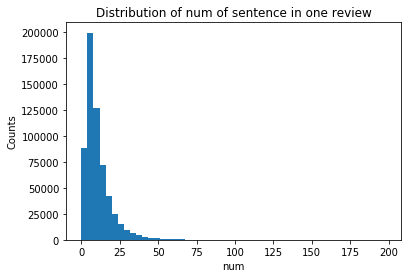

In [ ]:
plt.figure()
_ = plt.hist(num_sens, bins = 50)
plt.title('Distribution of num of sentence in one review')
plt.xlabel('num')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

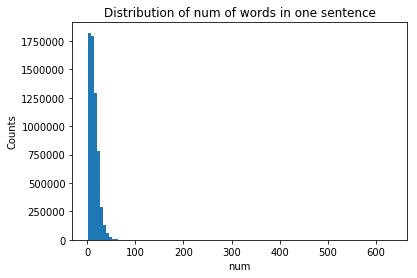

In [ ]:
plt.figure()
_ = plt.hist(num_words, bins = 100)
plt.title('Distribution of num of words in one sentence')
plt.xlabel('num')
plt.ylabel('Counts')

In [ ]:
word_count = {}
def count_words(x):
    for sen in x:
        for word in sen:
            word_count[word] = word_count.get(word, 0) + 1
_ = df_train.Processed_Reviews.apply(count_words)

In [ ]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [ ]:
vocab_size = 40000
df_word_count = df_word_count[:vocab_size-10]

In [ ]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 10 # reverse 10 pos for padding, [UNK], [CLS]...

In [ ]:
def word_to_num(x):
    res = []
    for sen in x:
        sen_words = []
        for word in sen:
            if word in word2num_series:
                sen_words.append(word2num_series[word])
        if len(sen_words) > 0:
            res.append(np.array(sen_words, dtype=np.uint16))
    return np.array(res)

In [ ]:
def create_data(df):
    X = df.Processed_Reviews.apply(word_to_num)
    y = df.label
    return X, y

In [ ]:
X_train, y_train = create_data(df_train)
X_val, y_val = create_data(df_validate)
X_test, y_test = create_data(df_test)

In [ ]:
X_train.to_hdf(data_pth + 'X_train.h5', key='s', model='w')
y_train.to_hdf(data_pth + 'y_train.h5', key='s', model='w')

X_val.to_hdf(data_pth + 'X_val.h5', key='s', model='w')
y_val.to_hdf(data_pth + 'y_val.h5', key='s', model='w')

X_test.to_hdf(data_pth + 'X_test.h5', key='s', model='w')
y_test.to_hdf(data_pth + 'y_test.h5', key='s', model='w')
word2num_series.to_hdf(data_pth + 'word2num_series.h5', key='s', model='w')

## Douban

In [7]:
data_pth = 'dataset/Douban/'

In [8]:
df = pd.read_csv(data_pth + 'train.csv')
df_test = pd.read_csv(data_pth + 'test.csv')

In [10]:
df['Processed_Reviews'] = df['content'].apply(process_zh)
df_test['Processed_Reviews'] = df_test['content'].apply(process_zh)
df_train, df_validate = train_test_split(df, test_size=50000, random_state=0, stratify=df.label)
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  550000
Validation set size:  50000
Test set size:  100000


In [11]:
num_words = []
def count(x):
    for sen in x:
        num_words.append(len(sen))
num_sens = df_train.Processed_Reviews.apply(len)
_ = df_train.Processed_Reviews.apply(count)

Text(0, 0.5, 'Counts')

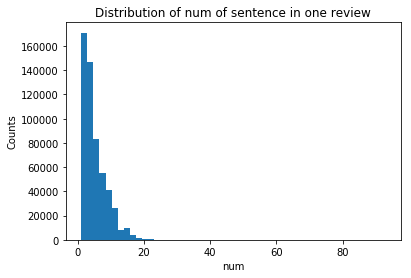

In [12]:
plt.figure()
_ = plt.hist(num_sens, bins = 50)
plt.title('Distribution of num of sentence in one review')
plt.xlabel('num')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

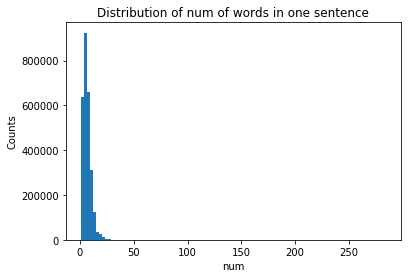

In [13]:
plt.figure()
_ = plt.hist(num_words, bins = 100)
plt.title('Distribution of num of words in one sentence')
plt.xlabel('num')
plt.ylabel('Counts')

In [14]:
word_count = {}
def count_words(x):
    for sen in x:
        for word in sen:
            word_count[word] = word_count.get(word, 0) + 1
_ = df_train.Processed_Reviews.apply(count_words)

In [29]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [30]:
vocab_size = 40000
df_word_count = df_word_count[1:vocab_size-10]

In [33]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 10 # reverse 10 pos for padding, [UNK], [CLS]...

In [35]:
def word_to_num(x):
    res = []
    for sen in x:
        sen_words = []
        for word in sen:
            if word in word2num_series:
                sen_words.append(word2num_series[word])
        if len(sen_words) > 0:
            res.append(np.array(sen_words, dtype=np.uint16))
    return np.array(res)

In [36]:
def create_data(df):
    X = df.Processed_Reviews.apply(word_to_num)
    y = df.label
    return X, y

In [37]:
X_train, y_train = create_data(df_train)
X_val, y_val = create_data(df_validate)
X_test, y_test = create_data(df_test)

In [38]:
X_train.to_hdf(data_pth + 'X_train.h5', key='s', model='w')
y_train.to_hdf(data_pth + 'y_train.h5', key='s', model='w')

X_val.to_hdf(data_pth + 'X_val.h5', key='s', model='w')
y_val.to_hdf(data_pth + 'y_val.h5', key='s', model='w')

X_test.to_hdf(data_pth + 'X_test.h5', key='s', model='w')
y_test.to_hdf(data_pth + 'y_test.h5', key='s', model='w')
word2num_series.to_hdf(data_pth + 'word2num_series.h5', key='s', model='w')

In [39]:
X_train = pd.read_hdf(data_pth + 'X_train.h5', key='s')